# 1. American Sign Language (ASL)¶

Created model that predicts american sign language(ASL) using CNN

In [1]:
import numpy as np
np.random.seed(5) 
import tensorflow as tf
tf.random.set_seed(2)
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2

train_dir = "../source_data//asl_alphabet_train/asl_alphabet_train"
eval_dir = "../source_data/asl-alphabet-test/asl-alphabet-test"

# 2. Loading the data

Since the data is held in multiple folders in the directories, it is necessary to extract it and store it in arrays. 

In [2]:
def load_images_func(directory_1):
    images = []
    labels = []
    for index, label in enumerate(unique_labels):
        for file in os.listdir(directory_1 + "/" + label):
            filepath = directory_1 + "/" + label + "/" + file
            image = cv2.resize(cv2.imread(filepath), (64, 64))
            images.append(image)
            labels.append(index)
    images = np.array(images)
    labels = np.array(labels)
    return(images, labels)

In [3]:
import keras

unique_labels = sorted(os.listdir(train_dir))
images, labels = load_images_func(directory = train_dir)

if unique_labels == sorted(os.listdir(eval_dir)):
    X_eval, y_eval = load_images_func(directory = eval_dir)

Using TensorFlow backend.


Once I have loaded the data, it is time to begin an understanding of it. The code below gives us some basic details about the data.



In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size = 0.1, stratify = labels)

n = len(unique_labels)
train_1 = len(X_train)
test_1= len(X_test)

print("Total number of symbols: ", n) #includes space, nothing and delete
print("Number of training images: " , train_1) 
print("Number of testing images: ", test_1)

eval_1 = len(X_eval)
print("Number of evaluation images: ", eval_1)

Total number of symbols:  29
Number of training images:  78300
Number of testing images:  8700
Number of evaluation images:  870


We see that we have a total of 29 symbols. These are the letters A to Z, and symbols for delete, space and nothing. Our total images from the first dataset, 87000 in number, have been split into training images - 78300, and testing images - 8700. We also have an additional 870 evaluation images from a different directory.

# 3. Printing images

We are now ready to print the images for the symbols. I will print one image for each symbol, from each dataset - train, test and evaluation. Since the same operation of printing images is done thrice, I will now write a helper function for this purpose. This function will create a grid of 8x4 images and fill 29 images in the first 29 of the 32 spaces.

In [5]:
#Helper function to print images
def print_images(image_list):
    n = int(len(image_list) / len(unique_labels))
    cols = 8
    rows = 4
    fig = plt.figure(figsize = (24, 12))

    for i in range(len(unique_labels)):
        ax = plt.subplot(rows, cols, i + 1)
        plt.imshow(image_list[int(n*i)])
        plt.title(unique_labels[i])
        ax.title.set_fontsize(20)
        ax.axis('off')
    plt.show()

Training Images: 


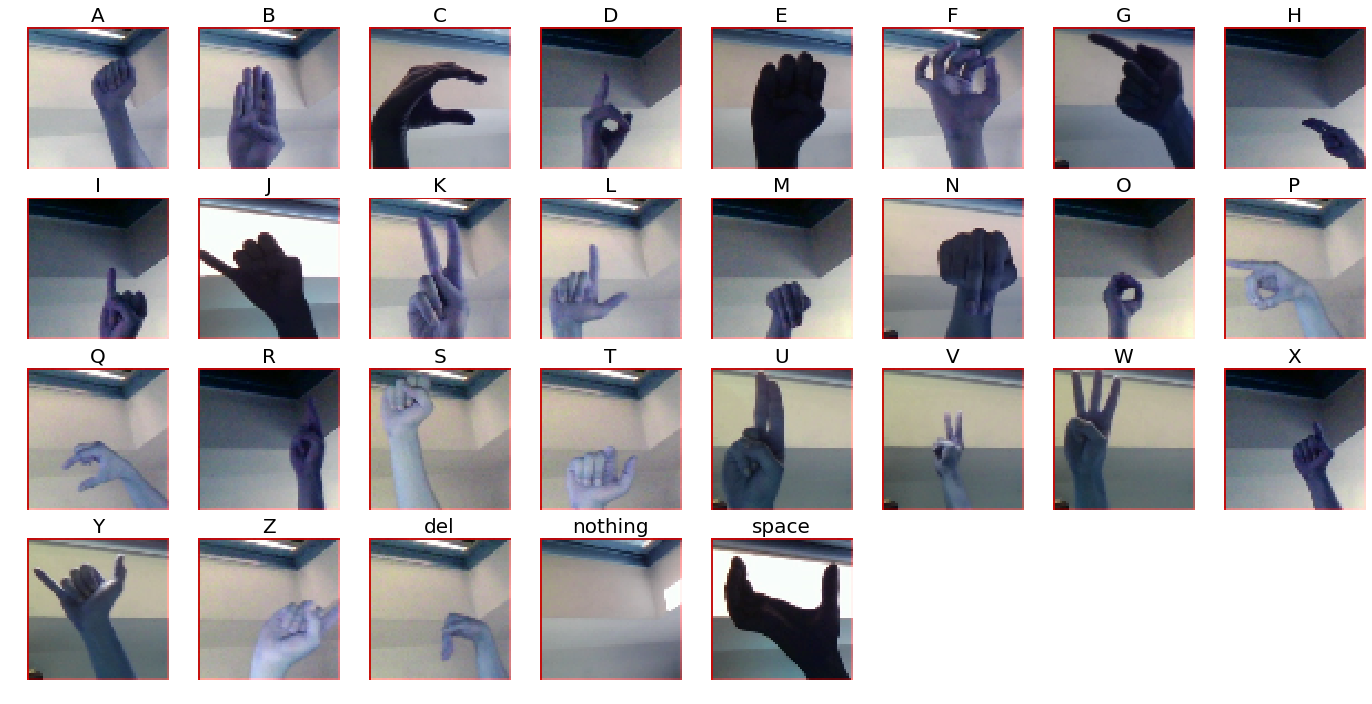

In [6]:
y_train_in = y_train.argsort()
y_train = y_train[y_train_in]
X_train = X_train[y_train_in]

print("Training Images: ")
print_images(image_list = X_train)

Notice how the training images are all in a similar environment, with a combination of lights and shadows. We will address these issues later.

Let us now print the testing images.

Testing images: 


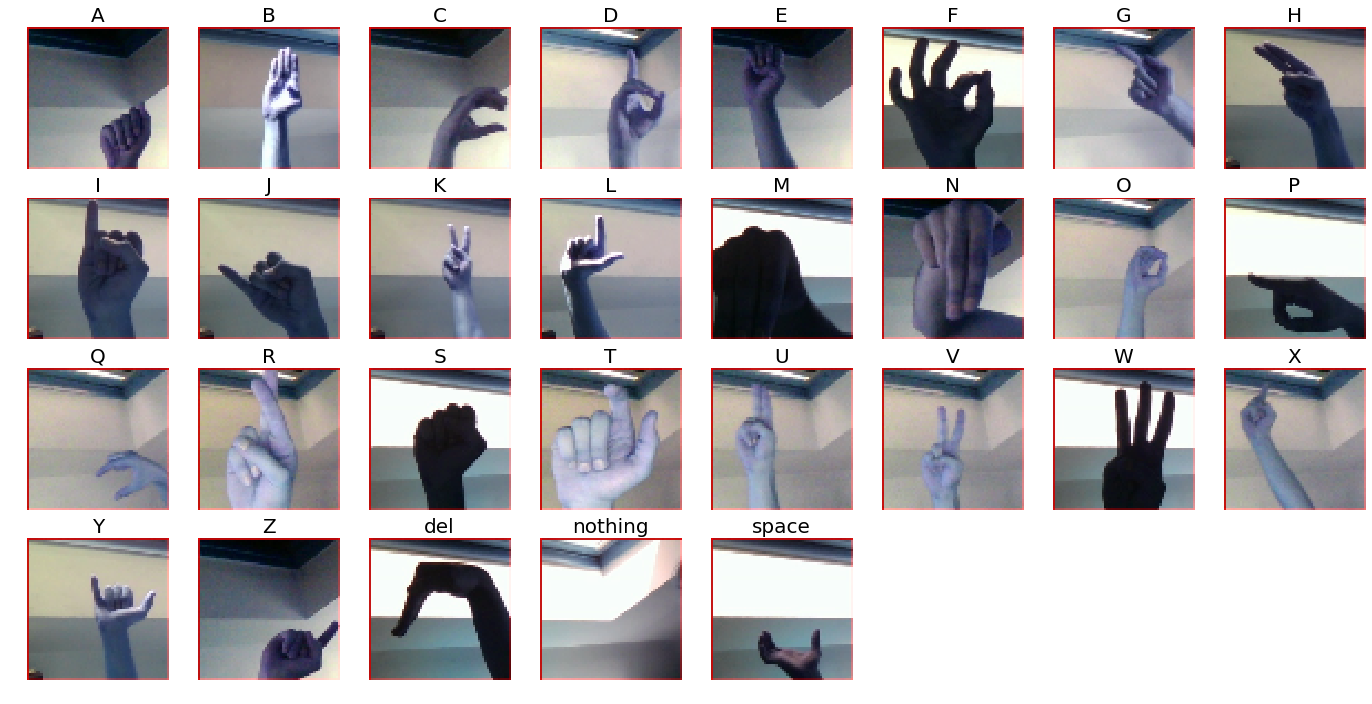

In [7]:
y_test_in = y_test.argsort()
y_test = y_test[y_test_in]
X_test = X_test[y_test_in]

print("Testing images: ")
print_images(image_list = X_test)

Evaluation images: 


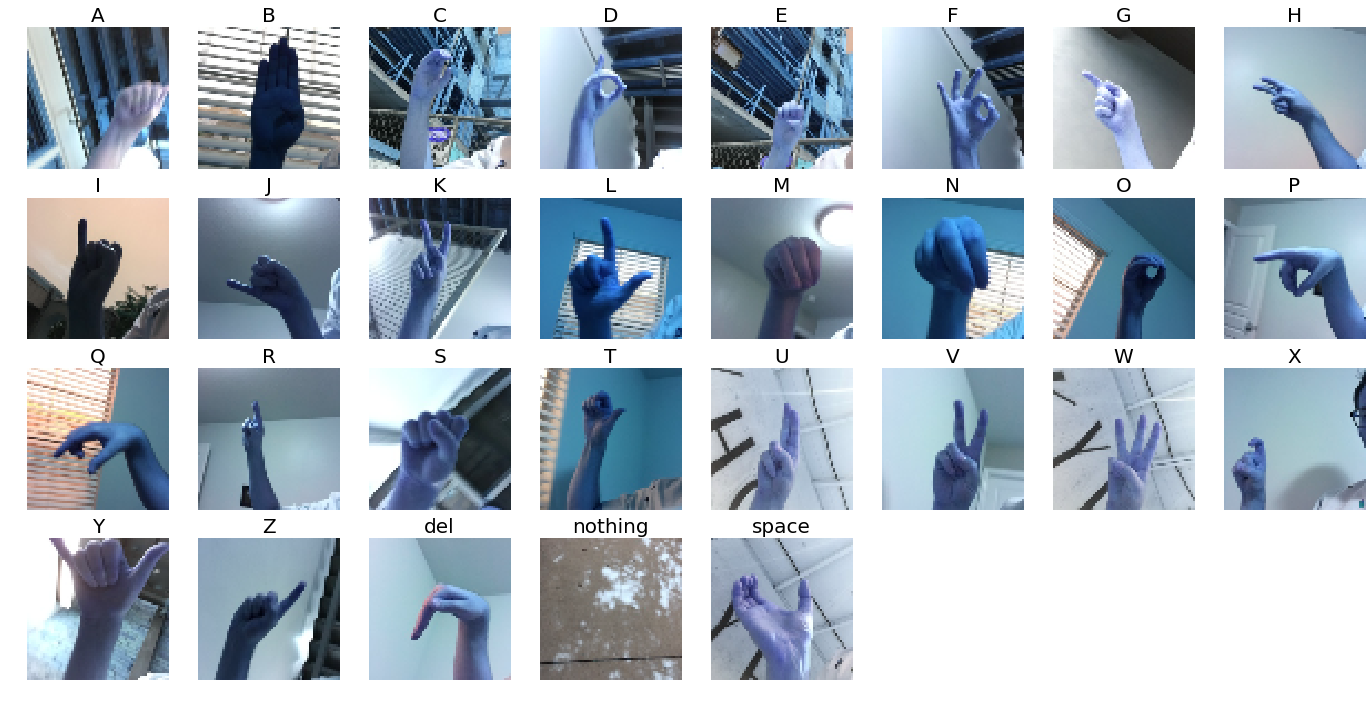

In [8]:
print("Evaluation images: ")
print_images(image_list = X_eval)

# 4. Preprocessing: One-hot enconding the data


One-hot encoding is easy to do using `keras`:

In [9]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)
y_eval = keras.utils.to_categorical(y_eval)

Now we can have a look at one of the labels to see if it is indeed one-hot encoded:

In [10]:
print(y_train[0])
print(len(y_train[0]))

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.]
29



# 5. Preprocessing - Normalize RGB values

Now let us look at how the image data is stored. There are three components for each image - one component each for the Red, Green, and Blue (RGB) channels. The component values are stored as integer numbers in the range 0 to 255, the range that a single 8-bit byte can offer. 

Normalization will help us remove distortions caused by lights and shadows in an image. This is a good idea for our dataset as we have seen that our images have a lot of different light and shadow areas.


In [11]:
X_train = X_train.astype('float32')/255.0
X_test = X_test.astype('float32')/255.0
X_eval = X_eval.astype('float32')/255.0

# 5. Define and run the model

I will define a deep learning model, a convolutional neural network (CNN) to classify the data. This network accepts an image of an American Sign Language letter as input. The output layer returns the network's predicted probabilities that the image belongs in each category.

We'll add the following layers:

*     MaxPooling. This passes a (4, 4) moving window over the image and downscales the image by outputting the maximum value within the window.
*     Dropout. This prevents the model from overfitting, i.e. perfectly remembering each image, by randomly setting a percentage of the input units to 0 at each update during training.
*     Conv2D. Add further convolutional layers since deeper models, i.e. models with more convolutional layers, are better able to learn features from images.
*     Flatten. As its name suggests, this flattens the output from the convolutional part of the CNN into a one-dimensional feature vector which can be passed into the following fully connected layers.
*     Dense. Fully connected layer where every input is connected to every output.


In [12]:
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Conv2D, Dense, Dropout, Flatten
from keras.layers import Flatten, Dense
from keras.models import Sequential

model = Sequential()
model.add(Conv2D(filters = 64, kernel_size = 5, padding = 'same', activation = 'relu', 
                 input_shape = (64, 64, 3)))
model.add(Conv2D(filters = 64, kernel_size = 5, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (4, 4)))
model.add(Dropout(0.5))
model.add(Conv2D(filters = 128 , kernel_size = 5, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 128 , kernel_size = 5, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (4, 4)))
model.add(Dropout(0.5))
model.add(Conv2D(filters = 256 , kernel_size = 5, padding = 'same', activation = 'relu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(29, activation='softmax'))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 64)        4864      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
conv2d_4 (Conv2D)    

After having defined a neural network in `keras`, the next step is to compile it.

In [13]:
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [14]:
hist = model.fit(X_train, y_train, epochs = 5, batch_size = 64)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
78300/78300 [==============================] - 37s 473us/step - loss: 1.2242 - acc: 0.6307
Epoch 2/5
78300/78300 [==============================] - 31s 399us/step - loss: 0.1702 - acc: 0.9465
Epoch 3/5
78300/78300 [==============================] - 31s 398us/step - loss: 0.1206 - acc: 0.9652
Epoch 4/5
78300/78300 [==============================] - 31s 398us/step - loss: 0.1118 - acc: 0.9715
Epoch 5/5
78300/78300 [==============================] - 31s 397us/step - loss: 0.1129 - acc: 0.9743


# 7. Test the model

We can now test the model on our testing and evaluation images. We are looking to note the difference between how the model performs with the testing images vs the evaluation or real-world images.

In [15]:
score = model.evaluate(x = X_test, y = y_test, verbose = 0)
print('Accuracy for test images:', round(score[1]*100, 3), '%')
score = model.evaluate(x = X_eval, y = y_eval, verbose = 0)
print('Accuracy for evaluation images:', round(score[1]*100, 3), '%')

Accuracy for test images: 99.828 %
Accuracy for evaluation images: 46.667 %
